In [1]:
import numpy as np
import random
import imageio
import matplotlib.pyplot as plt

In [16]:
class Agent():
    """
    Base class for agents in a simulation environment.
    """
    def __init__(self, idx):
        """
        Initializes an agent with a unique identifier.
        
        Parameters:
            idx (int): An identifier unique to each agent.
        """
        self.idx = idx

class GreedyAgent(Agent):
  """
  A subclass of Agent that implements a greedy strategy for decision-making. 
  This agent decides on actions based on immediate rewards, with some exploration.
  """
  def __init__(self, idx, discount_rate=0.9, exploration_rate=0.1):
    """
    Initializes a GreedyAgent with specific rates for discount and exploration.
    
    Parameters:
        idx (int): An identifier unique to each agent.
        discount_rate (float): Rate at which future rewards are discounted back to their present value.
        exploration_rate (float): Probability of choosing a random action to explore the environment.
    """
    super().__init__(idx)
    self.possible_actions = {0:'collects apples',
                             1:'fires beam',
                             2:'walks right',
                             3:'walks left',
                             4:'walks down',
                             5:'walks up'}
    self.score = 0
    self.discount_rate = discount_rate
    self.exploration_rate = exploration_rate

  def step(self, state):
    """
    Decides the next action for the agent based on the current state of the environment.
    
    Parameters:
        state (dict): Contains the current state of the environment and necessary information for decision-making.
    
    Returns:
        int: The chosen action as an integer.
    """
    # print(f'Agent {self.idx} is looking around.')
    # Extract the agent's current view from the environment state.
    self.view = state['agent_views'][self.idx]
    # Determine the agent's current position within its view.
    pos = tuple(np.argwhere(self.view == str(self.idx))[0])

    # Calculate the number of apples and waste within the agent's view.
    apples = np.sum(self.view == 'A')
    # print(f'Agent {self.idx} can see {apples} apple(s).')
    waste = np.sum(self.view[pos[0],:pos[1]] == '#')
    # print(f'Agent {self.idx} can clean {waste} waste.')
    
    # EVALUATE ACTIONS
    view_h, view_w = self.view.shape
    
    mask = np.zeros_like(self.view, dtype=float)
    # Compute mask values based on Manhattan distance from the agent's position.
    for i in range(view_h):
        for j in range(view_w):
            distance_x = abs(i - pos[0])
            distance_y = abs(j - pos[1])
            if   distance_x <= 1 and distance_y <= 1:
                mask[i, j] = 1.0
            elif distance_x <= 2 and distance_y <= 2 and (distance_x + distance_y) <= 3:
                mask[i, j] = 0.7
            else:
                mask[i, j] = 0.5
    masked_view = (self.view=='A') * mask

    # Calculate the potential of each action based on the masked view.
    action_potential = {}
    action_potential[0] = np.sum(masked_view[np.clip(pos[0]-1,0,view_h):np.clip(pos[0]+2,0,view_h),np.clip(pos[1]-1,0,view_w):np.clip(pos[1]+2,0,view_w)])
    action_potential[2] = np.sum(masked_view[np.clip(pos[0]-1,0,view_h):np.clip(pos[0]+2,0,view_h),np.clip(pos[1]-0,0,view_w):np.clip(pos[1]+3,0,view_w)])
    action_potential[3] = np.sum(masked_view[np.clip(pos[0]-1,0,view_h):np.clip(pos[0]+2,0,view_h),np.clip(pos[1]-2,0,view_w):np.clip(pos[1]+1,0,view_w)])
    action_potential[4] = np.sum(masked_view[np.clip(pos[0]-0,0,view_h):np.clip(pos[0]+3,0,view_h),np.clip(pos[1]-1,0,view_w):np.clip(pos[1]+2,0,view_w)])
    action_potential[5] = np.sum(masked_view[np.clip(pos[0]-2,0,view_h):np.clip(pos[0]+1,0,view_h),np.clip(pos[1]-1,0,view_w):np.clip(pos[1]+2,0,view_w)])

    # POLICY
    while True:
      # CHOOSE ACTION
      if np.random.rand() < self.exploration_rate or action_potential[0] == 0:
        # Exploration: choose a random action
        action = np.random.randint(1,6)
      else:
        action = max(action_potential, key=action_potential.get)

      # CHECK IF ACTION IS VALID, IF NOT TRY DIFFERENT ACTION
      if   action == 0 or action == 1:
        break
      elif action == 2:
        if pos[1] + 1 < view_w and self.view[pos[0], pos[1] + 1] == '_': 
            break
        else:
          action_potential[2] = 0.0
      elif action == 3:
        if pos[1] - 1 > 0 and self.view[pos[0], pos[1] - 1] == '_': 
            break
        else:
          action_potential[3] = 0.0
      elif action == 4:
        if pos[0] + 1 < view_h and self.view[pos[0] + 1, pos[1]] == '_': 
            break
        else:
          action_potential[4] = 0.0
      elif action == 5:
        if pos[0] - 1 > 0 and self.view[pos[0] - 1, pos[1]] == '_': 
          break
        else:
          action_potential[5] = 0.0
    
    # print(f'Agent {self.idx} {self.possible_actions[action]}.')
    return action
  
class SkillAgent(Agent):
  """
  An agent that adjusts its behavior based on learned skills and the environment's current state. It inherits from the Agent class.

  Attributes:
      discount_rate (float): Discount rate for future rewards, affecting how future values are discounted into the present value.
      exploration_rate (float): Rate at which the agent explores new actions versus exploiting known actions.
      possible_actions (dict): Descriptions of possible actions the agent can take.
      score (int): Current score of the agent, reflecting its performance.
  """
  def __init__(self, idx, discount_rate=0.9, exploration_rate=0.1, skill_bool=True):
    """
    Initializes a SkillAgent with specific parameters.

    Parameters:
        idx (int): Unique identifier for the agent.
        discount_rate (float): Discount factor for future rewards.
        exploration_rate (float): Probability of choosing a random action to explore the environment.
    """
    super().__init__(idx)
    self.possible_actions = {0:'collects apples',
                             1:'fires beam',
                             2:'walks right',
                             3:'walks left',
                             4:'walks down',
                             5:'walks up'}
    self.score = 0
    self.discount_rate = discount_rate
    self.exploration_rate = exploration_rate
    self.skill_bool = skill_bool

  def set_skill_factor(self, state):
    """
    Determines the agent's skill level based on recent actions.

    Parameters:
        state (dict): The current state of the environment, including the agent's action history.
    
    Returns:
        tuple: The last skill used and the score associated with that skill.
    """
    # Filter actions related to skills
    skill_seq = [a for a in state['action_history'][self] if a in [0,1]]
    # Initialize skill score
    skill_score = 0
    # Determine the last skill used
    last_skill = skill_seq[-1] if len(skill_seq) > 0 else None
    # Calculate skill score based on consecutive uses of the last skill
    while len(skill_seq) > 0:
      if last_skill == skill_seq[-1]:
        # Increment skill score for repeated use
        skill_score += 0.5 # TO ADD: How to define skill
        # Remove the last action from consideration
        skill_seq = skill_seq[:-1]
      else:
        break
    return last_skill, skill_score
  
  def calculate_apple_potential(self, pos):
    """
    Calculates the potential for collecting apples based on the agent's position.

    Parameters:
        pos (tuple): The agent's current position.

    Returns:
        apple_view (numpy.ndarray): A mask representing the apple collection potential from the current position.
    """
    view_h, view_w = self.view.shape

    apple_mask = np.zeros_like(self.view, dtype=float)
    # Create a mask based on Manhattan distances to determine apple collection potential
    for i in range(view_h):
      for j in range(view_w):
        distance_x = abs(j - pos[1])
        distance_y = abs(i - pos[0])
        if   distance_x <= 1 and distance_y <= 1:
          apple_mask[i, j] = 1.0
        elif distance_x <= 2 and distance_y <= 2 and (distance_x + distance_y) <= 3:
          apple_mask[i, j] = 0.7
        elif distance_x <= 3 and distance_y <= 3 and (distance_x + distance_y) <= 5:
          apple_mask[i, j] = 0.4
        else:
          apple_mask[i, j] = 0.1
    apple_view = (self.view=='A') * apple_mask
    return apple_view

  def calculate_waste_potential(self, pos):
    """
    Calculates the potential for cleaning waste based on the agent's position.

    Parameters:
        pos (tuple): The agent's current position.

    Returns:
        waste_view (numpy.ndarray): A mask representing the waste cleaning potential from the current position.
    """
    view_h = self.view.shape[0]
    view_w = self.view.shape[1]    
    waste_mask = np.zeros_like(self.view, dtype=float)
    # Similar to calculate_apple_potential but focuses on cleaning waste
    for i in range(view_h):
      for j in range(view_w):
        distance_x = abs(j - pos[1])
        distance_y = abs(i - pos[0])
        if   distance_y <= 0:
          waste_mask[i, j] = 0.8
        elif distance_y <= 1:
          waste_mask[i, j] = 0.5
        elif distance_x <= 2:
          waste_mask[i, j] = 0.3
        else:
          waste_mask[i, j] = 0.1
    waste_view = (self.view=='#') * waste_mask
    # print(waste_view)
    return waste_view

  def step(self, state):
    """
    Decides on the next action for the agent based on its skills and the current state.

    Parameters:
        state (dict): The current state of the environment.

    Returns:
        action (int): The chosen action.
    """
    # print(f'Agent {self.idx} is looking around.')
    # Current view of the agent
    self.view = state['agent_views'][self.idx]
    # Position of the agent
    pos = tuple(np.argwhere(self.view == str(self.idx))[0])

    # apples = np.sum(self.view == 'A')
    # print(f'Agent {self.idx} can see {apples} apple(s).')
    # waste = np.sum(self.view[pos[0],:pos[1]] == '#')
    # print(f'Agent {self.idx} can clean {waste} waste.')
    
    # EVALUATE SKILL
    # Initialize skill array
    skill = np.ones(2)
    if self.skill_bool == True:
      last_skill, skill_score = self.set_skill_factor(state)
      # Adjust skill score based on last action
      if last_skill is not None:
        skill[last_skill] = skill_score


    # EVALUATE ACTIONS
    view_h, view_w = self.view.shape
    # Dictionary to store potential for each action
    action_potential = {}

    # Calculate action potentials for different actions based on skills and environmental data
    action_potential[0] = skill[0] * np.sum(self.calculate_apple_potential(pos)) + skill[1] * 0.0
    action_potential[1] = skill[0] * 0.0 + skill[1] * np.sum(self.calculate_waste_potential(pos))
    action_potential[2] = skill[0] * np.sum(self.calculate_apple_potential((pos[0],np.clip(pos[1]+1,0,view_w-1)))[:,np.clip(1,0,view_w-1):]) + skill[1] * np.sum(self.calculate_waste_potential((pos[0],np.clip(pos[1]+1,0,view_w-1)))[:,np.clip(1,0,view_w-1):])
    action_potential[3] = skill[0] * np.sum(self.calculate_apple_potential((pos[0],np.clip(pos[1]-1,0,view_w)))[:,:np.clip(view_w-1,0,view_w):]) + skill[1] * np.sum(self.calculate_waste_potential((pos[0],np.clip(pos[1]-1,0,view_w)))[:,:np.clip(view_w-1,0,view_w):])
    action_potential[4] = skill[0] * np.sum(self.calculate_apple_potential((np.clip(pos[0]+1,0,view_h-1),pos[1]))[np.clip(1,0,view_h-1):,:]) + skill[1] * np.sum(self.calculate_waste_potential((np.clip(pos[0]+1,0,view_h-1),pos[1]))[np.clip(1,0,view_h-1):,:])
    action_potential[5] = skill[0] * np.sum(self.calculate_apple_potential((np.clip(pos[0]-1,0,view_h),pos[1]))[np.clip(view_h-1,0,view_h):,:]) + skill[1] * np.sum(self.calculate_waste_potential((np.clip(pos[0]-1,0,view_h),pos[1]))[:np.clip(view_h-1,0,view_h),:])
    

    # POLICY
    while True:
      # CHOOSE ACTION
      if np.random.rand() < self.exploration_rate or (action_potential[0] == 0.0 and action_potential[1] == 0.0):
        # Exploration
        action = np.random.randint(2,6)
      else:
        # Exploitation
        action = max(action_potential, key=action_potential.get)

      # CHECK IF ACTION IS VALID, IF NOT TRY DIFFERENT ACTION
      if   action == 0 or action == 1:
        break
      
      elif action == 2:
        if pos[1] < view_w - 1 and self.view[pos[0], pos[1] + 1] == '_': 
            break
        else:
          action_potential[2] = 0.0
      elif action == 3:
        if pos[1] > 0 and self.view[pos[0], pos[1] - 1] == '_': 
            break
        else:
          action_potential[3] = 0.0
      elif action == 4:
        if pos[0] < view_h - 1 and self.view[pos[0] + 1, pos[1]] == '_': 
            break
        else:
          action_potential[4] = 0.0
      elif action == 5:
        if pos[0] > 0 and self.view[pos[0] - 1, pos[1]] == '_': 
          break
        else:
          action_potential[5] = 0.0
    
    # print(f'Agent {self.idx} {self.possible_actions[action]}.')
    return action
  

class Cleanup():
  """
  Represents a cleanup game environment where agents interact with a grid to collect apples and clean waste.

  Attributes:
      agents (list): A list of agents participating in the environment.
      state (dict): A dictionary holding the current state of the environment, including agent views and histories.
      map_legend (dict): A legend mapping symbols to their meanings in the environment.
      view_size (int): The size of the area visible to each agent.
      map (numpy.ndarray): The grid representing the game environment.
  """
  def __init__(self, agents=[], view_size=3):
    """
    Initializes the Cleanup environment with a set of agents and a specified view size.

    Parameters:
        agents (list): A list of agents to include in the environment.
        view_size (int): The radius of the square area visible to each agent.
    """
    self.agents = agents
    self.state = {}
    self.map_legend = {'orchard':'_',
                       'river':'~',
                       'apple':'A',
                       'waste':'#'}
    self.view_size = view_size
    self.create_map()
    self.reset()

  def reset(self):
    """
    Resets the environment to its initial state, including action, reward, and communication histories.
    """
    # ACTION HISTORY
    # print('Resetting action history.')
    self.action_history = {agent:[] for agent in self.agents}
    self.state['action_history'] = self.action_history.copy()
    # REWARD HISTORY
    # print('Resetting reward history.')
    self.reward_history = {agent:[] for agent in self.agents}
    self.state['reward_history'] = self.reward_history.copy()
    # MAP HISTORY
    # print('Resetting map history.')
    self.state['map_history'] = {0:self.map.copy()}
    # COMMUNICATION HISTORY
    self.comm_history = {agent:[] for agent in self.agents}
    self.state['comm_history'] = self.comm_history.copy()
    # SCORES
    for agent in self.agents:
      agent.score = 0
      agent.last_skill = None
      agent.skill_factor = 0

  def generate_apples(self, num_apples=1):
    """
    Randomly generates a specified number of apples in the orchard area of the map.
    """
    # print(f'Generating {num_apples} apple(s) in the orchard.')
    apples = 0
    while apples < num_apples:
      spawn_loc = (random.randint(0, 9), random.randint(4, 9))
      if self.map[spawn_loc] == self.map_legend['orchard']:
        self.map[spawn_loc] = self.map_legend['apple']
        apples += 1

  def generate_waste(self, num_waste=1):
    """
    Randomly generates a specified number of waste blocks in the river area of the map.
    """
    # print(f'Generating {num_waste} block(s) of waste in the river.')
    waste = 0
    while waste < num_waste:
      spawn_loc = (random.randint(0, 9), random.randint(0, 3))
      if self.map[spawn_loc] == self.map_legend['river']:
        self.map[spawn_loc] = self.map_legend['waste']
        waste += 1

  def generate_players(self):
    """
    Places agents at random locations within the orchard area of the map.
    """
    # print(f'Generating {len(self.agents)} player(s).')
    self.agent_positions = []
    while len(self.agent_positions) < len(self.agents):
      i = random.randint(0, 9)
      j = random.randint(4, 9)
      if self.map[i,j] == self.map_legend['orchard']:
        self.map[i,j] = str(len(self.agent_positions))
        self.agent_positions.append((i,j))
  
  def get_agent_views(self):
    """
    Updates the view for each agent based on their position and the view size.
    """
    agent_views = []
    for i, j in self.agent_positions:
      agent_views.append(self.map[np.clip(i-self.view_size, 0, 10) : np.clip(i+self.view_size+1, 0, 10),
                                  np.clip(j-self.view_size, 0, 10) : np.clip(j+self.view_size+1, 0, 10)])
    self.state['agent_views'] = agent_views

  def create_map(self):    
    """
    Initializes the game map with rivers, orchards, apples, and waste.
    """
    # print('Creating map.')
    self.map = np.full((10,10), self.map_legend['orchard'], dtype='U1') # set orchard 
    self.map[:,0:4] = self.map_legend['river'] # set river

    # self.generate_apples(16)
    self.generate_waste(16)
    self.generate_players()
    self.get_agent_views()
    
    # print(self.map)
    ''' Example map
    ['~' '~' '~' '~' '1' '_' '_' 'A' 'A' '_']
    ['~' '~' '~' '~' 'A' '_' '_' '_' '_' '_']
    ['~' '~' '~' '~' '_' '_' 'A' '0' 'A' '_']
    ['#' '~' '#' '~' 'A' '_' '_' '_' '_' '_']
    ['~' '~' '#' '~' '_' '_' 'A' '_' 'A' '_']
    ['~' '~' '~' '~' 'A' 'A' '_' '_' '_' 'A']
    ['~' '~' '~' '~' '_' '_' '_' '_' '_' '_']
    ['~' '~' '~' '#' '_' '_' 'A' 'A' '_' 'A']
    ['~' '~' '~' '~' '_' '_' '_' '_' '_' '_']
    ['~' '~' '~' '~' '_' 'A' 'A' '_' '_' '_']
    where:
    'orchard':'_',
    'river':'~',
    'apple':'A',
    'waste':'#',
    'agent_0':'0',
    'agent_1':'1'
    '''

  def update_map(self, action, agent):
    """
    Update the game map based on the action taken by an agent.

    This method handles different actions such as picking apples, clearing waste with a beam,
    and moving the agent in the map. Depending on the action, it updates the map accordingly
    and adjusts the agent's score or position.

    Parameters:
    - action (int): The action code the agent decides to take.
    - agent (Agent): The agent performing the action.

    Returns:
    - int: The number of apples picked if the action was picking apples, otherwise 0.
    """
    # Retrieve current agent position
    x, y = self.agent_positions[agent.idx]
    if   action == 0:
      # Define area where apples can be picked based on agent's position
      picking_area = self.map[np.clip(x-1,0,10):np.clip(x+2,0,10),np.clip(y-1,0,10):np.clip(y+2,0,10)]
      # print(picking_area)
      # Count and remove apples from the picking area
      apples_picked = np.sum(picking_area==self.map_legend['apple'])
      # print(f'Agent {agent.idx} has collected {apples_picked} apples(s).')
      picking_area[picking_area==self.map_legend['apple']] = self.map_legend['orchard']

      # Update agent's score based on apples picked
      agent.score += apples_picked
      return apples_picked
      
    elif action == 1:
      # Define beam area for clearing waste
      beam = self.map[np.clip(x,0,9),np.clip(y-5,0,9):np.clip(y,0,9)]
      # Count and clear waste blocks
      waste_cleared = np.sum([beam == '#'])
      # print(f'Agent {agent.idx}\'s beam has cleared {waste_cleared} block(s) of waste.')
      beam[beam == '#'] = '~'
      # TO ADD: punish agents for being hit by beam
      return 0
    elif action == 2:
      self.map[x,y] = '_'
      self.map[x,y+1] = str(agent.idx)
      self.agent_positions[agent.idx] = tuple((x,y+1))
      return 0
    elif action == 3:
      self.map[x,y] = '_'
      self.map[x,y-1] = str(agent.idx)
      self.agent_positions[agent.idx] = tuple((x,y-1))
      return 0
    elif action == 4:
      self.map[x,y] = '_'
      self.map[x+1,y] = str(agent.idx)
      self.agent_positions[agent.idx] = tuple((x+1,y))
      return 0
    elif action == 5:
      self.map[x,y] = '_'
      self.map[x-1,y] = str(agent.idx)
      self.agent_positions[agent.idx] = tuple((x-1,y))
      return 0

  
  def step(self, num_steps=1):
    """
    Perform simulation steps in the game environment.

    This method executes a series of actions for each agent and updates the game state accordingly.
    It also handles the generation of waste and apples based on the current state.

    Parameters:
    - num_steps (int): The number of steps to simulate.
    """
    for step in range(num_steps):

      # Handle waste and apple generation based on game conditions
      total_waste = np.sum(self.map == self.map_legend.get('waste'))
      # print('Waste:', total_waste/40)
      if total_waste < 16:
        if np.random.uniform() < 0.5:
          self.generate_waste()
          total_waste += 1
      
      if total_waste < 16:
        respawn_rate = (16 - total_waste) / 16 * 0.5
        if np.random.uniform() < respawn_rate:
          self.generate_apples()


      # Process actions for each agent
      for agent in self.agents:        
        action = agent.step(self.state)
        self.action_history[agent].append(action)
        self.comm_history[agent].append((agent.last_skill, agent.skill_factor))

        # print('Updating map.')
        reward = self.update_map(action, agent)
        self.reward_history[agent].append(agent.score)

        self.get_agent_views()

      # print(self.map)
        
      # Update state history after each step
      self.state['map_history'].update({(step+1):self.map.copy()})

  
  def evaluate(self, delta): 
    """
    Calculate the discounted return for each agent.

    Parameters:
    - delta (float): The discount factor used for calculating the return.

    Returns:
    - list: A list of discounted returns for each agent.
    """ 
    disc_returns = [np.sum([r * delta ** i for i, r in enumerate(self.reward_history[agent])]) for agent in self.agents]
    return disc_returns
  
  def visualize_map(self, output_name):
    """
    Visualize the game map over time and save it as a video file.

    This method goes through each step's map state and converts it into a color image.
    These images are then compiled into a video showing the progression of the game environment.
    """
    with imageio.get_writer(output_name, fps=2) as writer:
      for m, char_map in self.state['map_history'].items():
        color_map = []
        # Mapping characters to colors for visualization
        char_to_color = {'_':[  0,255,  0], # green
                         '~':[  0,  0,255], # blue
                         'A':[255,  0,  0], # red
                         '#':[139, 69, 19], # brown
                         '0':[255,255,  0], # yellow
                         '1':[255,  0,255], # magenta
                         '2':[  0,255,255], # cyan
                         }
        for i in range(10):
          for j in range(10):
            color_map.append(char_to_color[char_map[i,j]])

        # Create and append the frame for current step
        frame = np.array(color_map, dtype=np.uint8).reshape((10,10,3))
        frame = np.repeat(frame, 50, axis=0)
        frame = np.repeat(frame, 50, axis=1)
        writer.append_data(frame)

  def plot_rewards(self):
    """
    Plot the cumulative score (apples picked) of the agents over time.

    This method visualizes the reward history of each agent to compare their performance.
    """
    # Plotting
    for agent in self.agents:
      plt.plot(self.reward_history[agent], label=f'Agent {agent.idx+1}')
    plt.plot([sum(values) for values in zip(*self.reward_history.values())], label=f'Total')


    # Adding labels and title
    plt.xlabel('Steps')
    plt.ylabel('Cumulative score (apples picked)')
    plt.title('Schelling diagram for Cleanup game')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()


In [17]:
num_iters = 100
num_steps = 200

3.6


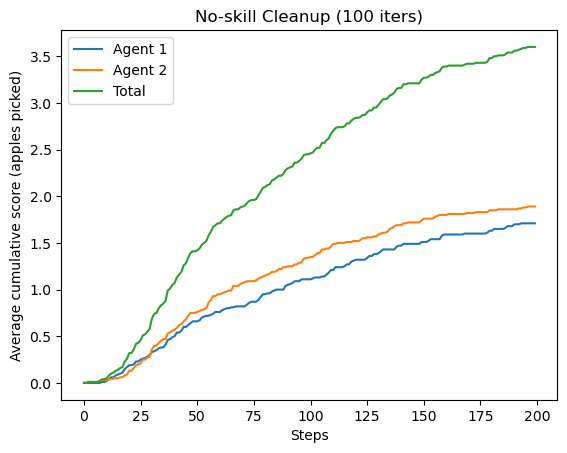

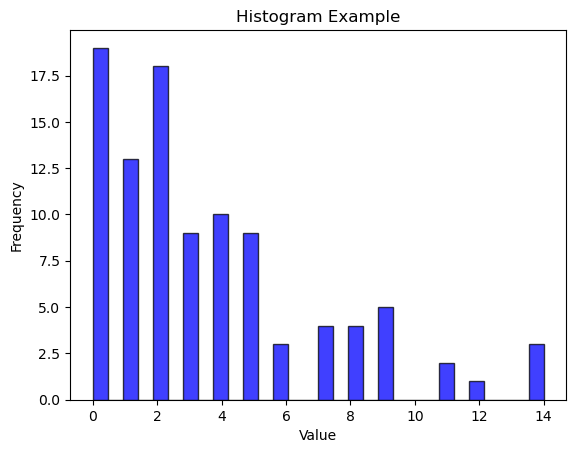

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [18]:
agents = [SkillAgent(idx=0, exploration_rate=0.2, skill_bool=False), # yellow
          SkillAgent(idx=1, exploration_rate=0.2, skill_bool=False), # magenta
        #   SkillAgent(idx=2, exploration_rate=0.2, skill_bool=False), # cyan
          ]

noskill_mean_total_running_scores = []
noskill_mean_individual_running_scores = []
for g in range(num_iters):
  game = Cleanup(agents)
  game.step(num_steps)
  noskill_mean_total_running_scores.append(np.array([sum(v) for v in zip(*game.reward_history.values())]))
  noskill_mean_individual_running_scores.append(np.array([v for v in zip(*game.reward_history.values())]))

# print(np.mean(noskill_mean_total_running_scores, axis=0))
print(np.mean(noskill_mean_total_running_scores, axis=0)[-1])
# print(np.mean(noskill_mean_individual_running_scores,axis=0).T)

for agent in game.agents:
  plt.plot(np.mean(noskill_mean_individual_running_scores,axis=0).T[agent.idx], label=f'Agent {agent.idx+1}')
plt.plot(np.mean(noskill_mean_total_running_scores, axis=0), label=f'Total')
# Adding labels and title
plt.xlabel('Steps')
plt.ylabel('Average cumulative score (apples picked)')
plt.title(f'No-skill Cleanup ({num_iters} iters)')
plt.legend()
plt.show()

# Create a histogram
plt.hist([x[-1] for x in noskill_mean_total_running_scores], bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

game.visualize_map('no_skill_game.mp4')


7.22


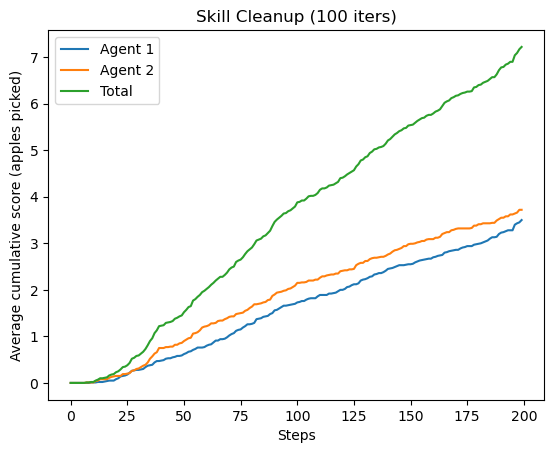

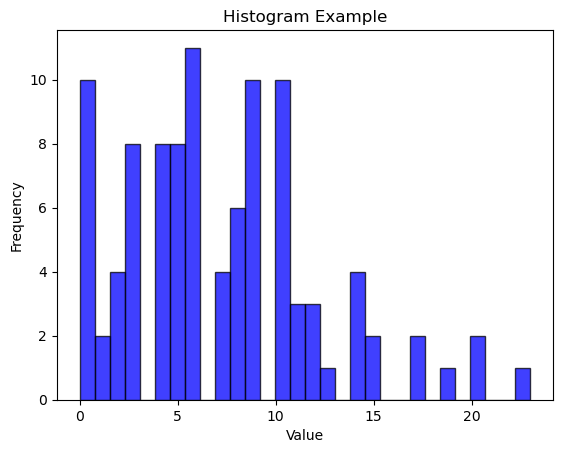

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [19]:
agents = [SkillAgent(idx=0, exploration_rate=0.2, skill_bool=True), # yellow
          SkillAgent(idx=1, exploration_rate=0.2, skill_bool=True), # magenta
        #   SkillAgent(idx=2, exploration_rate=0.2, skill_bool=True), # cyan
          ]

skill_mean_total_running_scores = []
skill_mean_ind_running_scores = []
for g in range(num_iters):
  game = Cleanup(agents)
  game.step(num_steps)
  skill_mean_total_running_scores.append(np.array([sum(v) for v in zip(*game.reward_history.values())]))
  skill_mean_ind_running_scores.append(np.array([v for v in zip(*game.reward_history.values())]))

# print(np.mean(mean_total_running_scores, axis=0))
print(np.mean(skill_mean_total_running_scores, axis=0)[-1])
# print(np.mean(mean_ind_running_scores,axis=0).T)

for agent in game.agents:
  plt.plot(np.mean(skill_mean_ind_running_scores,axis=0).T[agent.idx], label=f'Agent {agent.idx+1}')
plt.plot(np.mean(skill_mean_total_running_scores, axis=0), label=f'Total')
# Adding labels and title
plt.xlabel('Steps')
plt.ylabel('Average cumulative score (apples picked)')
plt.title(f'Skill Cleanup ({num_iters} iters)')
plt.legend()
plt.show()

# Create a histogram
plt.hist([x[-1] for x in skill_mean_total_running_scores], bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

game.visualize_map('skill_game.mp4')



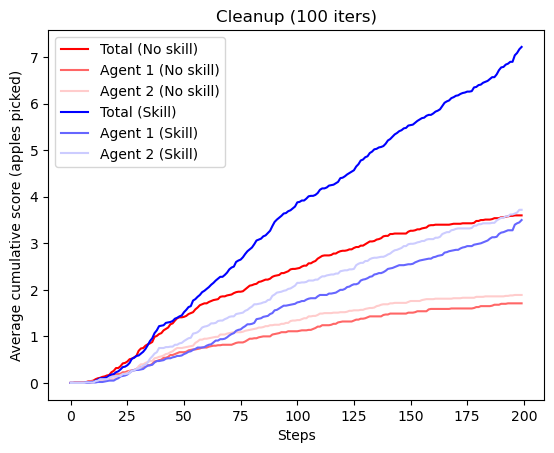

In [20]:
plt.plot(np.mean(noskill_mean_total_running_scores, axis=0), label=f'Total (No skill)', color=(1, 0, 0))
for agent in game.agents:
  plt.plot(np.mean(noskill_mean_individual_running_scores,axis=0).T[agent.idx], label=f'Agent {agent.idx+1} (No skill)', color=(1, 0.4+0.4*agent.idx, 0.4+0.4*agent.idx))
plt.plot(np.mean(skill_mean_total_running_scores, axis=0), label=f'Total (Skill)', color=(0, 0, 1))
for agent in game.agents:
  plt.plot(np.mean(skill_mean_ind_running_scores,axis=0).T[agent.idx], label=f'Agent {agent.idx+1} (Skill)', color=(0.4+0.4*agent.idx, 0.4+0.4*agent.idx, 1))

# Adding labels and title
plt.xlabel('Steps')
plt.ylabel('Average cumulative score (apples picked)')
plt.title(f'Cleanup ({num_iters} iters)')
plt.legend()
plt.show()

In [ ]:
agents = [SkillAgent(idx=0, exploration_rate=0.2, skill_bool=True), # yellow
          SkillAgent(idx=1, exploration_rate=0.2, skill_bool=True), # magenta
        #   SkillAgent(idx=2, exploration_rate=0.2, skill_bool=True), # cyan
          ]

game = Cleanup(agents)
game.step(500)

game.visualize_map('skill_game.mp4')

In [ ]:
# # GET SKILL SCORES
# if len(state['comm_history'][self]) > 0:
#   skill_scores = [y[-1] for _,y in state['comm_history'].items()]
#   print(f'Skill scores: {skill_scores}')
#   scores = []
#   for elem in skill_scores:
#     if elem[0] == action:
#       scores.append(elem[1])
#   if len(scores) > 0:
#     if self.skill_factor < np.max(scores):
#       print(f'Action {action} is unavailable.')